# EJERCICIO FINAL PYSPARK (DOCKER + KAFKA + PYSPARK)

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.sql.window import Window


## Creamos la sesión de spark

In [2]:
spark = (
    SparkSession.builder
        .appName("ProyectoIoT")
        .getOrCreate()
)
spark

spark.readStream
Indica que vamos a leer datos en modo streaming, es decir, datos que llegan continuamente.

.format("kafka")
Le decimos a Spark que la fuente de datos de streaming será Kafka.

.option("kafka.bootstrap.servers", "kafka:9092")
Especifica la dirección del clúster Kafka al que conectarse.
En este caso "kafka" es el nombre del contenedor Docker y 9092 es el puerto del broker.

.option("subscribe", "sensores")
Indica el topic de Kafka del que queremos leer mensajes → "sensores".

.option("startingOffsets", "latest")
Define desde qué punto empezar a leer:

"latest" → solo recibe mensajes nuevos, enviados después de iniciar el streaming.

"earliest" sería para leer todos los mensajes antiguos también.

.load()
Ejecuta la configuración y crea un DataFrame de streaming, donde cada fila representa un mensaje recibido desde Kafka.

In [3]:
raw_df = (
    spark.readStream
         .format("kafka")
         .option("kafka.bootstrap.servers", "kafka:9092")  # <-- nombre del contenedor
         .option("subscribe", "sensores")
         .option("startingOffsets", "latest")
         .load()
)


Este bloque transforma los mensajes de Kafka en un formato que Spark puede procesar:

Define la estructura de los datos que esperamos recibir (sensor, valor, temperatura, humedad, estado, timestamp y UUID).

Convierte el JSON recibido en columnas individuales para poder trabajar con cada campo.

Crea una columna de tiempo (event_time) a partir del timestamp original para poder usarlo en ventanas y agregaciones temporales.

In [4]:
schema = StructType([
    StructField("sensor_id", StringType()),
    StructField("value", DoubleType()),
    StructField("temperature", DoubleType()),
    StructField("humidity", DoubleType()),
    StructField("status", StringType()),
    StructField("timestamp", DoubleType()),
    StructField("uuid", StringType())
])

df = raw_df.select(
    from_json(col("value").cast("string"), schema).alias("data")
).select("data.*")

df = df.withColumn("event_time", col("timestamp").cast("timestamp"))


Este bloque realiza agregaciones por ventana de tiempo sobre el DataFrame de streaming:

Define un watermark de 1 minuto para indicar a Spark hasta qué punto los datos antiguos se pueden considerar válidos. Esto ayuda a manejar retrasos y datos tardíos.

Agrupa los datos cada 30 segundos por sensor (sensor_id).

Calcula estadísticas dentro de cada ventana: promedio de valor, temperatura y humedad, y cuenta el número de eventos recibidos.

El resultado es un DataFrame de streaming con resúmenes temporales por sensor listo para análisis o escritura.

In [5]:
agg_df = (
    df
    .withWatermark("event_time", "1 minute")   # ← IMPORTANTE
    .groupBy(
        window(col("event_time"), "30 seconds"),
        col("sensor_id")
    )
    .agg(
        avg("value").alias("avg_value"),
        avg("temperature").alias("avg_temp"),
        avg("humidity").alias("avg_humidity"),
        count("*").alias("num_events")
    )
)


Este bloque escribe los resultados del streaming en archivos Parquet de manera continua:

Define la carpeta de salida donde se guardarán los archivos Parquet (resultados/).

Usa un checkpoint (chk/) para que Spark recuerde qué datos ya procesó y pueda reiniciar de forma segura en caso de fallo.

Modo append: los nuevos datos se agregan continuamente a los archivos existentes.

Inicia el streaming, haciendo que las agregaciones se escriban en tiempo real mientras llegan nuevos datos.

El resultado es un conjunto de archivos Parquet que refleja las métricas agregadas por ventana y por sensor.

In [6]:
parquet_query = (
    agg_df
    .writeStream
    .format("parquet")
    .option("path", "resultados/")
    .option("checkpointLocation", "chk/")
    .outputMode("append")
    .start()
)


A partir de aquí, te toca a ti, sigue las cuestiones planteadas en el Readme y completa el notebook. Despues guardatelo con los outputs de las celdas y súbelo al repo. Mucha suerte que ya lo teneis ;)

### Ejercicio 1

In [10]:
df_final = spark.read.parquet("resultados/")
print("Esquema del DataFrame")
df_final.printSchema()
total_filas = df_final.count()
print(f"Número total de filas (ventanas procesadas): {total_filas}")
num_sensores = df_final.select("sensor_id").distinct().count()
print(f"Número de sensores distintos detectados: {num_sensores}")

Esquema del DataFrame
root
 |-- window: struct (nullable = false)
 |    |-- start: timestamp (nullable = true)
 |    |-- end: timestamp (nullable = true)
 |-- sensor_id: string (nullable = true)
 |-- avg_value: double (nullable = true)
 |-- avg_temp: double (nullable = true)
 |-- avg_humidity: double (nullable = true)
 |-- num_events: long (nullable = false)

Número total de filas (ventanas procesadas): 200
Número de sensores distintos detectados: 4


### Ejercicio 2

In [17]:
from pyspark.sql.functions import col, min, max, avg
df_relacion = df_final.withColumn("delta_clima", col("avg_temp") - col("avg_humidity")) # Representa la diferencia: Temperatura - Humedad
resultado = df_relacion.select(
    min("delta_clima").alias("Valor_Minimo"),
    max("delta_clima").alias("Valor_Maximo"),
    avg("delta_clima").alias("Valor_Medio")
)

resultado.show()

df_relacion.select("sensor_id", "avg_temp", "avg_humidity", "delta_clima").show(5)

+------------+-----------------+-------------------+
|Valor_Minimo|     Valor_Maximo|        Valor_Medio|
+------------+-----------------+-------------------+
|       -40.0|38.10666666666667|-0.5805049310411807|
+------------+-----------------+-------------------+

+---------+------------------+------------------+------------------+
|sensor_id|          avg_temp|      avg_humidity|       delta_clima|
+---------+------------------+------------------+------------------+
|       S1|62.754999999999995| 57.35166666666667| 5.403333333333329|
|       S3|             52.35| 58.25333333333333|-5.903333333333329|
|       S3|           56.9425| 66.00750000000001|-9.065000000000005|
|       S1| 53.88777777777778|             46.96| 6.927777777777777|
|       S4|            60.444|54.257999999999996| 6.186000000000007|
+---------+------------------+------------------+------------------+
only showing top 5 rows



### Ejercicio 3

In [19]:
from pyspark.sql.functions import col
condicion_humedad = col("avg_humidity") > 60
condicion_eventos = col("num_events") > 0
condicion_sensor = col("sensor_id") == "S1"

df_filtrado = df_final.filter(
    (condicion_humedad) & 
    (condicion_eventos) & 
    (condicion_sensor)
)
cantidad = df_filtrado.count()
print(f"Registros que cumplen todas las condiciones: {cantidad}")
df_filtrado.select("window", "sensor_id", "avg_humidity", "num_events").show(12, truncate=False)

Registros que cumplen todas las condiciones: 12
+------------------------------------------+---------+------------------+----------+
|window                                    |sensor_id|avg_humidity      |num_events|
+------------------------------------------+---------+------------------+----------+
|{2026-02-06 08:43:30, 2026-02-06 08:44:00}|S1       |61.44625          |8         |
|{2026-02-06 08:48:00, 2026-02-06 08:48:30}|S1       |68.39             |4         |
|{2026-02-06 08:51:30, 2026-02-06 08:52:00}|S1       |61.39333333333334 |6         |
|{2026-02-06 09:18:30, 2026-02-06 09:19:00}|S1       |61.39714285714285 |7         |
|{2026-02-06 09:19:00, 2026-02-06 09:19:30}|S1       |62.43222222222222 |9         |
|{2026-02-06 09:22:00, 2026-02-06 09:22:30}|S1       |61.68416666666666 |12        |
|{2026-02-06 08:43:00, 2026-02-06 08:43:30}|S1       |62.8              |5         |
|{2026-02-06 08:52:00, 2026-02-06 08:52:30}|S1       |67.38857142857144 |7         |
|{2026-02-06 08:5

### Ejercicio 4

In [25]:
from pyspark.sql.functions import avg, max, count, desc, col
df_stats = df_final.groupBy("sensor_id").agg(
    avg("avg_temp").alias("media_global_temp"),
    max("avg_temp").alias("max_temp_registrada"),
    count("*").alias("num_ventanas")
)
print("Tabla de estadísticas por sensor")
df_stats.show()

# Pregunta 1: ¿Qué sensor tiene la mayor media?
top_media = df_stats.orderBy(col("media_global_temp").desc()).first() #ordeno descendente y cojo el primero
print(f"Sensor con mayor media: {top_media['sensor_id']} (Media: {top_media['media_global_temp']:.2f}°C)")

# Pregunta 2: ¿Qué sensor presenta la temperatura máxima?
top_max = df_stats.orderBy(col("max_temp_registrada").desc()).first()
print(f"Sensor con el pico de calor más alto: {top_max['sensor_id']} (Máx: {top_max['max_temp_registrada']:.2f}°C)")

# Pregunta 3: ¿Cuántos grupos o ventanas existen por sensor?
print(f"Ventanas del sensor: {top_media['num_ventanas']}")

Tabla de estadísticas por sensor
+---------+------------------+-------------------+------------+
|sensor_id| media_global_temp|max_temp_registrada|num_ventanas|
+---------+------------------+-------------------+------------+
|       S4| 54.84483507936508|  71.31833333333334|          50|
|       S3| 53.25778634476634|  65.35000000000001|          50|
|       S1|53.468108038350536|  78.23166666666667|          50|
|       S2|55.561869515484524|  73.32833333333333|          50|
+---------+------------------+-------------------+------------+

Sensor con mayor media: S2 (Media: 55.56°C)
Sensor con el pico de calor más alto: S1 (Máx: 78.23°C)
Ventanas del sensor: 50


### Ejercicio 5

In [27]:
ventana = Window.partitionBy("sensor_id").orderBy(col("avg_value").desc())
df_ranked = df_final.withColumn("ranking", row_number().over(ventana))
df_maximos = df_ranked.filter(col("ranking") == 1).drop("ranking")

print("Máximos por sensor")
df_maximos.select("sensor_id", "window", "avg_value").show(truncate=False)
ganador_global = df_maximos.orderBy(col("avg_value").desc()).first()
print(f"SENSOR GANADOR GLOBAL: {ganador_global['sensor_id']}")
print(f"Valor máximo alcanzado: {ganador_global['avg_value']:.2f}")

Máximos por sensor
+---------+------------------------------------------+------------------+
|sensor_id|window                                    |avg_value         |
+---------+------------------------------------------+------------------+
|S1       |{2026-02-06 09:21:00, 2026-02-06 09:21:30}|38.791666666666664|
|S2       |{2026-02-06 08:50:00, 2026-02-06 08:50:30}|40.64             |
|S3       |{2026-02-06 08:49:30, 2026-02-06 08:50:00}|39.73666666666667 |
|S4       |{2026-02-06 08:44:30, 2026-02-06 08:45:00}|37.855            |
+---------+------------------------------------------+------------------+

SENSOR GANADOR GLOBAL: S2
Valor máximo alcanzado: 40.64


### Ejercicio 6

In [28]:
datos_info = [
    ("S1", "Almacén", "Industrial"),
    ("S2", "Servidores", "Precisión"),
    ("S3", "Oficinas", "Doméstico"),
    ("S4", "Exterior", "Meteorológico")
]

columnas_info = ["sensor_id", "ubicacion", "categoria"]
df_info_sensores = spark.createDataFrame(datos_info, columnas_info)
df_info_sensores.show()

# Usamos "left" para no perder datos del stream si falta info de algún sensor
df_unido = df_final.join(df_info_sensores, on="sensor_id", how="left")
df_unido.show(5, truncate=False)

+---------+----------+-------------+
|sensor_id| ubicacion|    categoria|
+---------+----------+-------------+
|       S1|   Almacén|   Industrial|
|       S2|Servidores|    Precisión|
|       S3|  Oficinas|    Doméstico|
|       S4|  Exterior|Meteorológico|
+---------+----------+-------------+

+---------+------------------------------------------+------------------+------------------+------------------+----------+---------+-------------+
|sensor_id|window                                    |avg_value         |avg_temp          |avg_humidity      |num_events|ubicacion|categoria    |
+---------+------------------------------------------+------------------+------------------+------------------+----------+---------+-------------+
|S4       |{2026-02-06 08:40:00, 2026-02-06 08:40:30}|28.074            |60.444            |54.257999999999996|5         |Exterior |Meteorológico|
|S3       |{2026-02-06 08:47:30, 2026-02-06 08:48:00}|25.59833333333333 |52.35             |58.25333333333333 |6   

### Ejercicio 7

In [31]:
df_temporal = df_final.withColumn("tiempo_truncado", date_trunc("minute", col("window.start"))) #redondeamos al minuto accediendo al window.start

df_resumen_tiempo = df_temporal.groupBy("tiempo_truncado").agg(
    count("*").alias("ventanas_por_minuto"),       # ¿Cuántas ventanas hay?
    avg("avg_humidity").alias("humedad_media")     # ¿Cuál es la humedad media?
)
df_resumen_tiempo.orderBy("tiempo_truncado").show(truncate=False)

+-------------------+-------------------+------------------+
|tiempo_truncado    |ventanas_por_minuto|humedad_media     |
+-------------------+-------------------+------------------+
|2026-02-06 08:40:00|8                  |52.133078754578754|
|2026-02-06 08:41:00|8                  |57.27570312499999 |
|2026-02-06 08:42:00|8                  |51.804026785714285|
|2026-02-06 08:43:00|8                  |58.528221153846154|
|2026-02-06 08:44:00|8                  |52.66175527597403 |
|2026-02-06 08:45:00|8                  |54.812916666666666|
|2026-02-06 08:46:00|8                  |50.685985119047615|
|2026-02-06 08:47:00|8                  |56.12555208333333 |
|2026-02-06 08:48:00|8                  |53.16910912698413 |
|2026-02-06 08:49:00|8                  |55.503462301587305|
|2026-02-06 08:50:00|8                  |60.02216666666667 |
|2026-02-06 08:51:00|8                  |53.71529017857143 |
|2026-02-06 08:52:00|4                  |54.12522619047619 |
|2026-02-06 09:18:00|8  

### Ejercicio 8

In [33]:
df_repartido = df_final.repartition(4,"sensor_id")
# spark_partition_id() es una función de bajo nivel que nos dice "en qué caja" cayó el dato
df_con_particion = df_repartido.withColumn("n_particion", spark_partition_id())
# Agrupamos por el número de partición para ver cuántas filas acabaron en cada una
distribucion = df_con_particion.groupBy("n_particion").count().orderBy("n_particion")
distribucion.show()

df_con_particion.select("n_particion", "sensor_id").distinct().show()

+-----------+-----+
|n_particion|count|
+-----------+-----+
|          0|   50|
|          1|  100|
|          3|   50|
+-----------+-----+

+-----------+---------+
|n_particion|sensor_id|
+-----------+---------+
|          0|       S3|
|          1|       S4|
|          1|       S2|
|          3|       S1|
+-----------+---------+



### Ejercicio 9

In [35]:
stats = df_final.select(
    avg("avg_temp").alias("media"),
    stddev("avg_temp").alias("desviacion") #calculamos promedio y desviación
).first()

media_global = stats["media"]
desviacion_global = stats["desviacion"]
umbral_anomalia = media_global + desviacion_global

print(f"Media: {media_global:.2f}")
print(f"Desviación Std: {desviacion_global:.2f}")
print(f"Umbral de anomalía definido: > {umbral_anomalia:.2f}")

df_anomalias = df_final.filter(col("avg_temp") > umbral_anomalia)

total_anomalos = df_anomalias.count()
print(f"Número total de registros anómalos: {total_anomalos}")

sensor_problematico = df_anomalias.groupBy("sensor_id") \
    .count() \
    .orderBy(col("count").desc()) \
    .first()

print(f"El sensor con más anomalías es: {sensor_problematico['sensor_id']} (con {sensor_problematico['count']} alertas)")

df_anomalias.select("sensor_id", "window", "avg_temp").show(5, truncate=False)

Media: 54.28
Desviación Std: 7.69
Umbral de anomalía definido: > 61.98
Número total de registros anómalos: 28
El sensor con más anomalías es: S2 (con 12 alertas)
+---------+------------------------------------------+------------------+
|sensor_id|window                                    |avg_temp          |
+---------+------------------------------------------+------------------+
|S1       |{2026-02-06 08:47:30, 2026-02-06 08:48:00}|62.754999999999995|
|S3       |{2026-02-06 08:44:00, 2026-02-06 08:44:30}|64.22333333333334 |
|S4       |{2026-02-06 08:44:00, 2026-02-06 08:44:30}|65.96714285714286 |
|S1       |{2026-02-06 08:44:30, 2026-02-06 08:45:00}|63.52090909090909 |
|S1       |{2026-02-06 08:51:30, 2026-02-06 08:52:00}|66.43333333333334 |
+---------+------------------------------------------+------------------+
only showing top 5 rows



### Ejercicio 10

In [37]:
peso_valor = 0.5
peso_temp = 0.3
peso_humedad = 0.2

df_con_score = df_final.withColumn(
    "puntuacion_final", #se crea la columna de puntuación
    (col("avg_value") * peso_valor) + 
    (col("avg_temp") * peso_temp) + 
    (col("avg_humidity") * peso_humedad)
)

ganador_score = df_con_score.orderBy(col("puntuacion_final").desc()).first()

df_con_score.select("sensor_id", "puntuacion_final", "avg_value", "avg_temp").show(5)

print(f"SENSOR CON MAYOR PUNTUACIÓN: {ganador_score['sensor_id']}")
print(f"Valor: {ganador_score['puntuacion_final']:.4f}")


+---------+-----------------+------------------+------------------+
|sensor_id| puntuacion_final|         avg_value|          avg_temp|
+---------+-----------------+------------------+------------------+
|       S1|43.02516666666667|25.456666666666667|62.754999999999995|
|       S3|40.15483333333333| 25.59833333333333|             52.35|
|       S3|           49.233|37.897499999999994|           56.9425|
|       S1|41.67666666666667|32.236666666666665| 53.88777777777778|
|       S4|          43.0218|            28.074|            60.444|
+---------+-----------------+------------------+------------------+
only showing top 5 rows

SENSOR CON MAYOR PUNTUACIÓN: S2
Valor: 52.8130


### Ejercicio 11

Convirtiendo datos de Spark a Pandas...


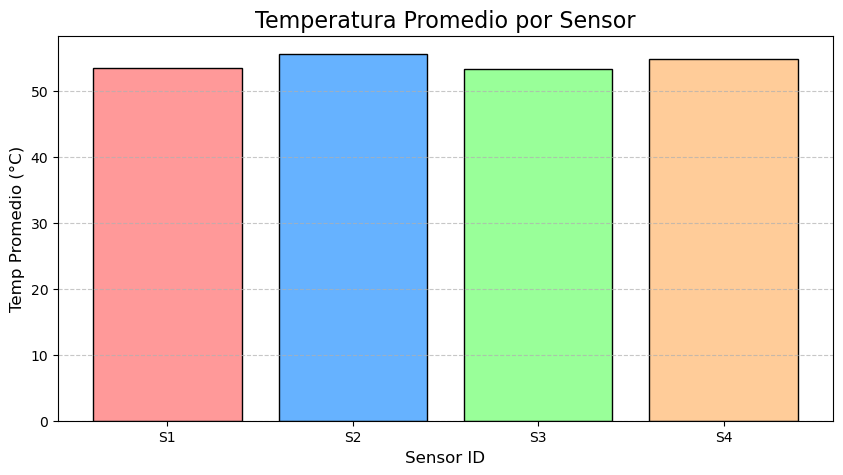

Gráfico de barras generado.


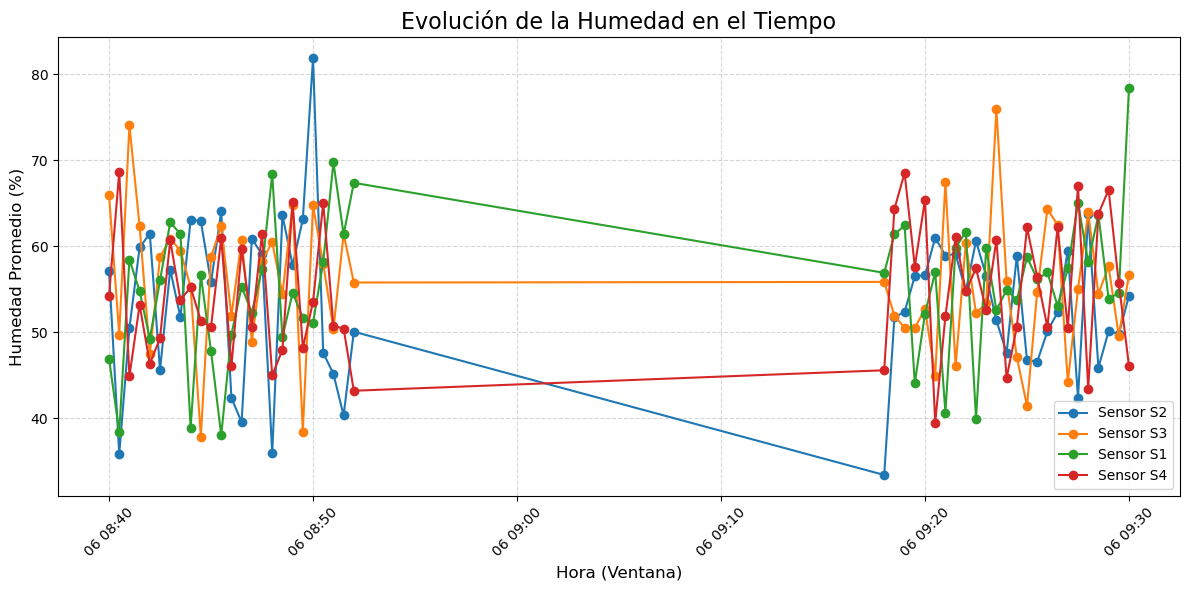

Gráfico de líneas generado.


In [38]:
import matplotlib.pyplot as plt
import pandas as pd

# Usamos limit(1000) para no sobrecargar la memoria si hubiera millones de datos
print("Convirtiendo datos de Spark a Pandas...")
pdf = df_final.orderBy("window").limit(1000).toPandas()

pdf['tiempo'] = pdf['window'].apply(lambda x: x['start'])
pdf = pdf.sort_values('tiempo')

plt.figure(figsize=(10, 5))

# Agrupamos en Pandas para sacar la media por sensor para el gráfico
pdf_resumen = pdf.groupby('sensor_id')['avg_temp'].mean().reset_index()

# Colores personalizados para cada barra
colores = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99']

plt.bar(pdf_resumen['sensor_id'], pdf_resumen['avg_temp'], color=colores, edgecolor='black')

plt.title('Temperatura Promedio por Sensor', fontsize=16)
plt.xlabel('Sensor ID', fontsize=12)
plt.ylabel('Temp Promedio (°C)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Guardamos el gráfico
plt.savefig('grafico_barras_sensores.png')
plt.show()
print("Gráfico de barras generado.")

plt.figure(figsize=(12, 6))

# Dibujamos una línea por cada sensor
for sensor in pdf['sensor_id'].unique():
    datos_sensor = pdf[pdf['sensor_id'] == sensor]
    plt.plot(datos_sensor['tiempo'], datos_sensor['avg_humidity'], marker='o', label=f'Sensor {sensor}')

plt.title('Evolución de la Humedad en el Tiempo', fontsize=16)
plt.xlabel('Hora (Ventana)', fontsize=12)
plt.ylabel('Humedad Promedio (%)', fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)

# Ajustar diseño para que no se corten las fechas
plt.tight_layout()

# Guardamos el gráfico
plt.savefig('grafico_lineas_tiempo.png')
plt.show()
print("Gráfico de líneas generado.")